# How to Train Kartezio
- config dataset
- set up parameters
- start training

note: Because Kartezio's source code has already been uploaded to the Python package index, we can directly download and use it.

pip install Kartezio

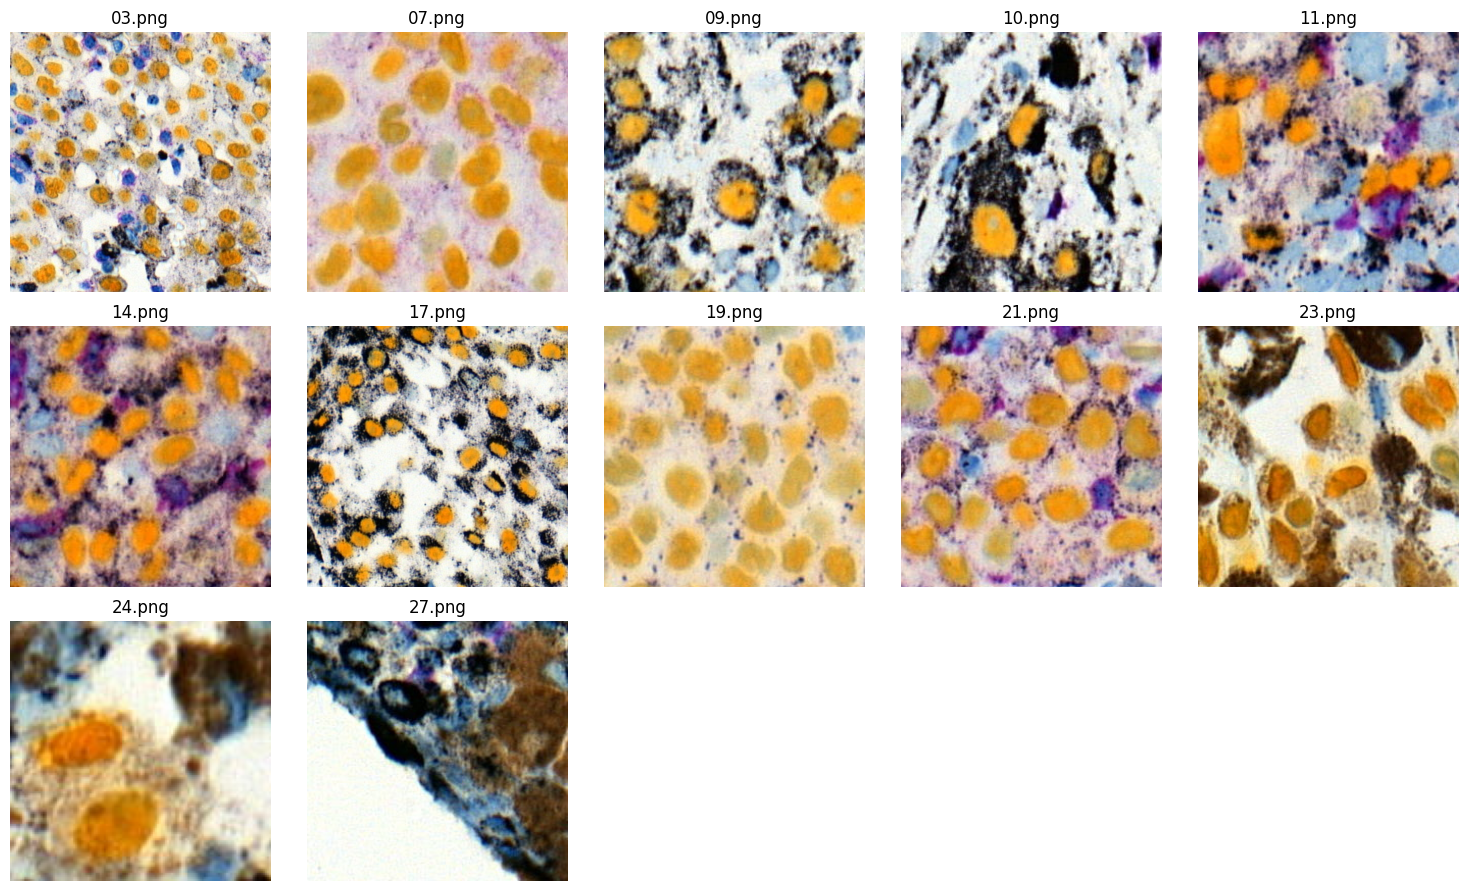

In [13]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def display_images_in_folder(folder_path):
    files = os.listdir(folder_path)
    image_files = [f for f in files if f.endswith('.png')]

    num_cols = 5
    num_images = len(image_files)
    num_rows = (num_images + num_cols - 1) // num_cols

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 3 * num_rows))
    axs = axs.flatten()

    for idx, image_file in enumerate(image_files):
        image_path = os.path.join(folder_path, image_file)
        img = mpimg.imread(image_path)
        axs[idx].imshow(img)
        axs[idx].axis('off')
        axs[idx].set_title(image_file)

    for j in range(idx + 1, len(axs)):
        axs[j].axis('off')
        
    plt.tight_layout()
    plt.show()

folder_path = './dataset/melanoma/train/train_x'
display_images_in_folder(folder_path)

## Config Dataset

In Kartezio, we need to use a json file to config the dataset:

```
{
    "name": "Melanoma",
    "scale": 1.0,
    "label_name": "melanoma",
    "mode": "dataframe",
    "input": {
        "type": "image",
        "format": "rgb"
    },
    "label": {
        "type": "roi",
        "format": "polygon"
    }
}
```
Where roi means the region of interest. 

In [14]:
from kartezio.apps.instance_segmentation import create_instance_segmentation_model
from kartezio.dataset import read_dataset
from kartezio.endpoint import (
    EndpointEllipse,
    EndpointHoughCircle,
    EndpointLabels,
    EndpointWatershed,
    LocalMaxWatershed,
)
from kartezio.preprocessing import TransformToHED, TransformToHSV
from kartezio.training import train_model
from numena.io.drive import Directory

RUNS = 10
ITERATIONS = 20000
LAMBDA = 5
COLORS_SCALES = ["RGB", "HSV", "HED"]


if __name__ == "__main__":
    output = './results'
    dataset_path = './dataset/melanoma'
    run_number = 10
    endpoint_name = 'MCW'

    color_scale_index = (run_number - 1) // RUNS
    color_scale = COLORS_SCALES[color_scale_index]
    output_directory = Directory(output).next(endpoint_name).next(color_scale)

    outputs = 1
    if endpoint_name == "MCW":
        outputs = 2
        endpoint = EndpointWatershed()
    elif endpoint_name == "LMW":
        endpoint = LocalMaxWatershed()
    elif endpoint_name == "ELLIPSE":
        endpoint = EndpointEllipse(min_axis=10, max_axis=65)
    elif endpoint_name == "HCT":
        endpoint = EndpointHoughCircle(
            min_dist=15, p1=32, p2=16, min_radius=5, max_radius=32
        )
    elif endpoint_name == "LABELS":
        endpoint = EndpointLabels()

    preprocessing = None
    if color_scale == "HSV":
        preprocessing = TransformToHSV()
    elif color_scale == "HED":
        preprocessing = TransformToHED()

    model = create_instance_segmentation_model(
        ITERATIONS,
        LAMBDA,
        inputs=3,
        outputs=outputs,
        endpoint=endpoint,
    )
    dataset = read_dataset(dataset_path)
    elite, _ = train_model(
        model, dataset, str(output_directory._path), preprocessing=preprocessing
    )

Files will be saved under results\MCW\RGB\377252-630d677c-c4e2-4a93-8fd7-82ab16ce0005.
[G 0001] 0.9167 0.005360s 187fps
[G 0002] 0.9155 0.052063s 19fps
[G 0003] 0.9149 0.072445s 14fps
[G 0004] 0.9116 0.042920s 23fps
[G 0005] 0.9116 0.050117s 20fps


KeyboardInterrupt: 

In [16]:
import cv2
import numpy as np
import pandas as pd
from kartezio.dataset import read_dataset
from kartezio.easy import print_stats
from kartezio.fitness import FitnessAP
from kartezio.inference import ModelPool
from kartezio.preprocessing import TransformToHED, TransformToHSV
from numena.image.basics import image_normalize
from numena.image.contour import contours_draw, contours_find
from train_model import COLORS_SCALES

dataset = read_dataset(f"./dataset/melanoma", counting=True, preview=True)

mode = "MCW"
color_scale = "HSV"# RGB & HSV

scores_all = {}
preprocessing = None

if color_scale == "HSV":  
    preprocessing = TransformToHSV()
if color_scale == "HED":  
    preprocessing = TransformToHED()
pool = ModelPool(
    f'./results/melanoma/{mode}/{color_scale}', FitnessAP(), regex="*/elite.json"
)
annotations_test = 0
annotations_training = 0
roi_pixel_areas = []
for y_true in dataset.train_y:
    n_annotations = y_true[1]
    annotations_training += n_annotations
for y_true in dataset.test_y:
    annotations = y_true[0]
    n_annotations = y_true[1]
    annotations_test += n_annotations
    for i in range(1, n_annotations + 1):
        roi_pixel_areas.append(np.count_nonzero(annotations[annotations == i]))
print(f"Total annotations for training set: {annotations_training}")
print(f"Total annotations for test set: {annotations_test}")
print(f"Mean pixel area for test set: {np.mean(roi_pixel_areas)}")

scores_test = []
scores_training = []
for i, model in enumerate(pool.models):
    # Test set

    p_test, fitness, t = model.eval(
        dataset, subset="test", preprocessing=preprocessing
    )

    scores_test.append(1.0 - fitness)
    for j, p_test_i in enumerate(p_test):
        visual = dataset.test_v[j]
        labels = p_test_i["labels"]
        n_labels = labels.max()
        for k in range(n_labels):
            labels_unique = labels.copy()
            labels_unique[labels_unique != k + 1] = 0
            visual = contours_draw(
                visual,
                contours_find(labels_unique.astype(np.uint8)),
                color=[72, 137, 62],
                thickness=2,
            )
        if "mask_raw" in p_test_i:
            cm_mask = cv2.applyColorMap(
                (image_normalize(p_test_i["mask_raw"]) * 255).astype(np.uint8),
                cv2.COLORMAP_VIRIDIS,
            )
        else:
            cm_mask = cv2.applyColorMap(
                (image_normalize(p_test_i["mask"]) * 255).astype(np.uint8),
                cv2.COLORMAP_VIRIDIS,
            )

    # Training set
    p_train, fitness, _ = model.eval(
        dataset, subset="train", preprocessing=preprocessing
    )
    scores_training.append(1.0 - fitness)

scores_all[f"training_{color_scale}"] = scores_training
scores_all[f"test_{color_scale}"] = scores_test
print_stats(scores_training, "AP50", f"{mode} {color_scale} training set")
print_stats(scores_test, "AP50", f"{mode} {color_scale} test set")

Total annotations for training set: 211
Total annotations for test set: 282
Mean pixel area for test set: 856.468085106383


F:\Peicheng Wu\HUST\3+1\24Spring\ECE 278A\project\code\kartezio\image\nodes.py:239: RuntimeWarning: invalid value encountered in cast
  return cv2.Sobel(x[0], cv2.CV_64F, 0, 1, ksize=ksize).astype(np.uint8)


-- Statistics for MCW HSV training set, using AP50 fitness:
Min 	 Mean +/- SD 	 Max
0.679 	 0.758+/-0.056 	 0.804
-- Statistics for MCW HSV test set, using AP50 fitness:
Min 	 Mean +/- SD 	 Max
0.634 	 0.690+/-0.046 	 0.746


## Pipeline Example

- Dataset: Melanoma
- Input Node: HSV
- Endpoint Node: MCW

<center><img src="./example_Kartezio.png" width=1200px alt="default"/></center>

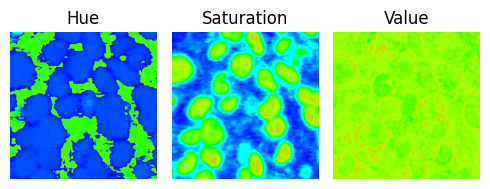

In [17]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

def apply_custom_colormap(channel):
    colors = [(0, 0, 5), (0, 2, 0), (0.8, 0.8, 0)]
    n_bins = 256 
    cmap_name = 'custom_colormap'
    cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)
    normalized_channel = channel / 255.0
    colored_image = cm(normalized_channel)
    colored_image = (colored_image[:, :, :3] * 255).astype(np.uint8)
    return colored_image

image_path = './dataset/melanoma/train/train_x/07.png'
img = cv2.imread(image_path)

img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
h, s, v = cv2.split(img_hsv)

h_colormap = apply_custom_colormap(h)
s_colormap = apply_custom_colormap(s)
v_colormap = apply_custom_colormap(v)

fig, axs = plt.subplots(1, 3, figsize=(5, 5))

axs[0].imshow(h_colormap)
axs[0].axis('off')
axs[0].set_title('Hue')

axs[1].imshow(s_colormap)
axs[1].axis('off')
axs[1].set_title('Saturation')

axs[2].imshow(v_colormap)
axs[2].axis('off')
axs[2].set_title('Value')

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Bitwise And')

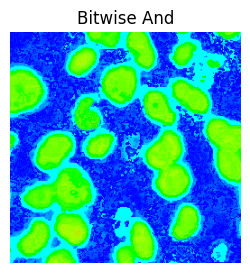

In [18]:
sv_and = cv2.bitwise_and(s, v)
sv_and_colormap = apply_custom_colormap(sv_and)

fig, axs = plt.subplots(1, 1, figsize=(3, 3))
axs.imshow(sv_and_colormap)
axs.axis('off')
axs.set_title('Bitwise And')

Text(0.5, 1.0, 'Morph. Open')

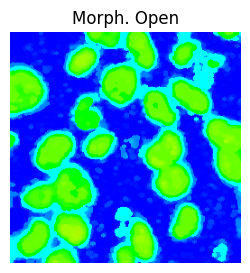

In [19]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
# denoise, smoothen, disconnect two cells
sv_and_open = cv2.morphologyEx(sv_and, cv2.MORPH_OPEN, kernel)# Open operator: Erosion first and then Dilation
sv_and_open_colormap = apply_custom_colormap(sv_and_open)

fig, axs = plt.subplots(1, 1, figsize=(3, 3))
axs.imshow(sv_and_open_colormap)
axs.axis('off')
axs.set_title('Morph. Open')

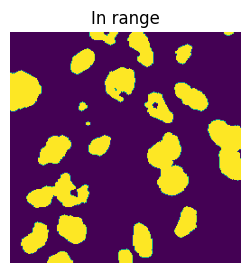

In [20]:
lower_bound = 139
upper_bound = 253

# do in range
inrange_result = cv2.inRange(sv_and_open, lower_bound, upper_bound)

inrange_colormap = apply_custom_colormap(inrange_result)

fig, axs = plt.subplots(1, 1, figsize=(3, 3))
axs.imshow(inrange_result)
axs.axis('off')
axs.set_title('In range')

plt.show()

Text(0.5, 1.0, 'Threshold')

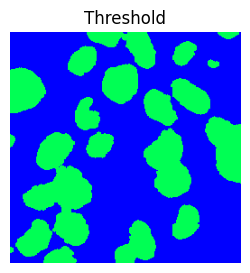

In [21]:
_, threshold_result = cv2.threshold(sv_and_open, 88, 119, cv2.THRESH_BINARY)

threshold_colormap = apply_custom_colormap(threshold_result)

fig, axs = plt.subplots(1, 1, figsize=(3, 3))
axs.imshow(threshold_colormap)
axs.axis('off')
axs.set_title('Threshold')

Text(0.5, 1.0, 'MCW')

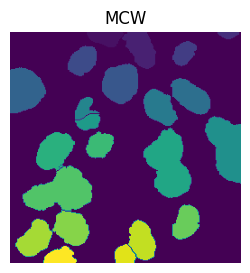

In [22]:
from numena.image.morphology import WatershedSkimage

mask = threshold_result
markers = inrange_result

wt = WatershedSkimage(use_dt=False, markers_distance=21, markers_area=None)
mask, markers, labels = wt.apply(mask, markers=markers, mask=mask > 0)

fig, axs = plt.subplots(1, 1, figsize=(3, 3))
axs.imshow(labels)
axs.axis('off')
axs.set_title('MCW')

## Other dataset

For easier tasks, Kartezio is powerful particularly to RGB cell segmentation

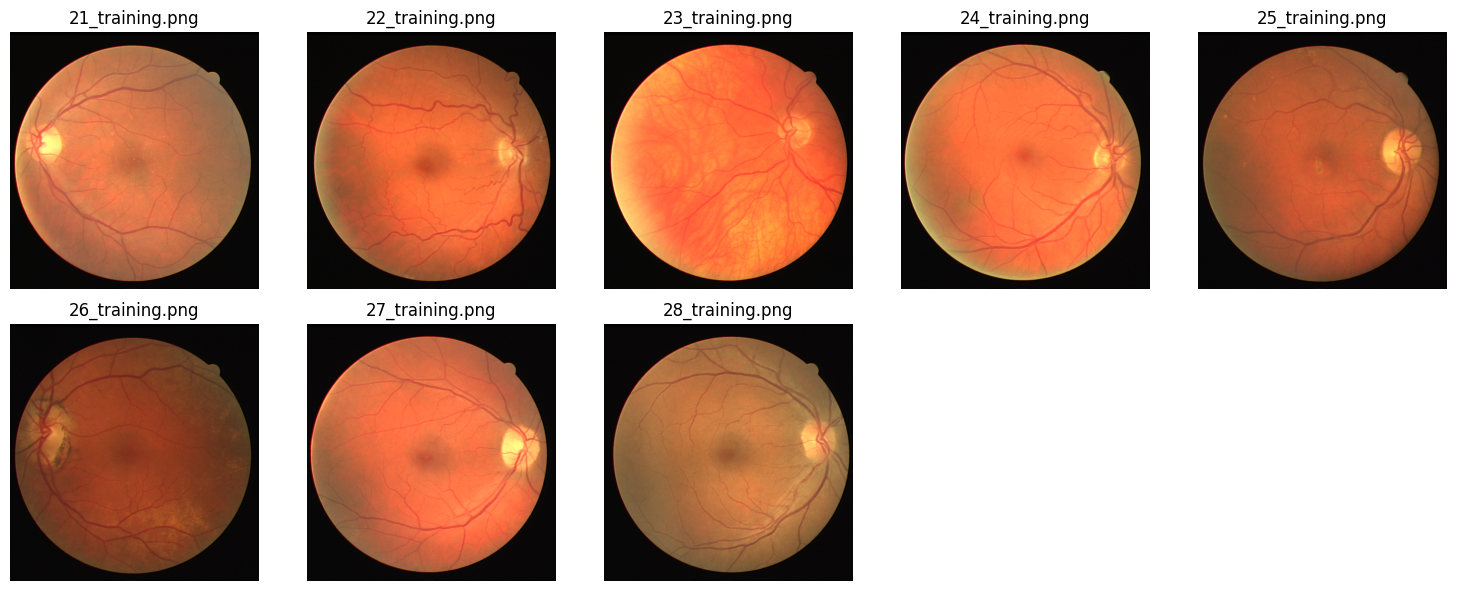

In [43]:
folder_path = './dataset/dataset_eye/train/train_x'
display_images_in_folder(folder_path)

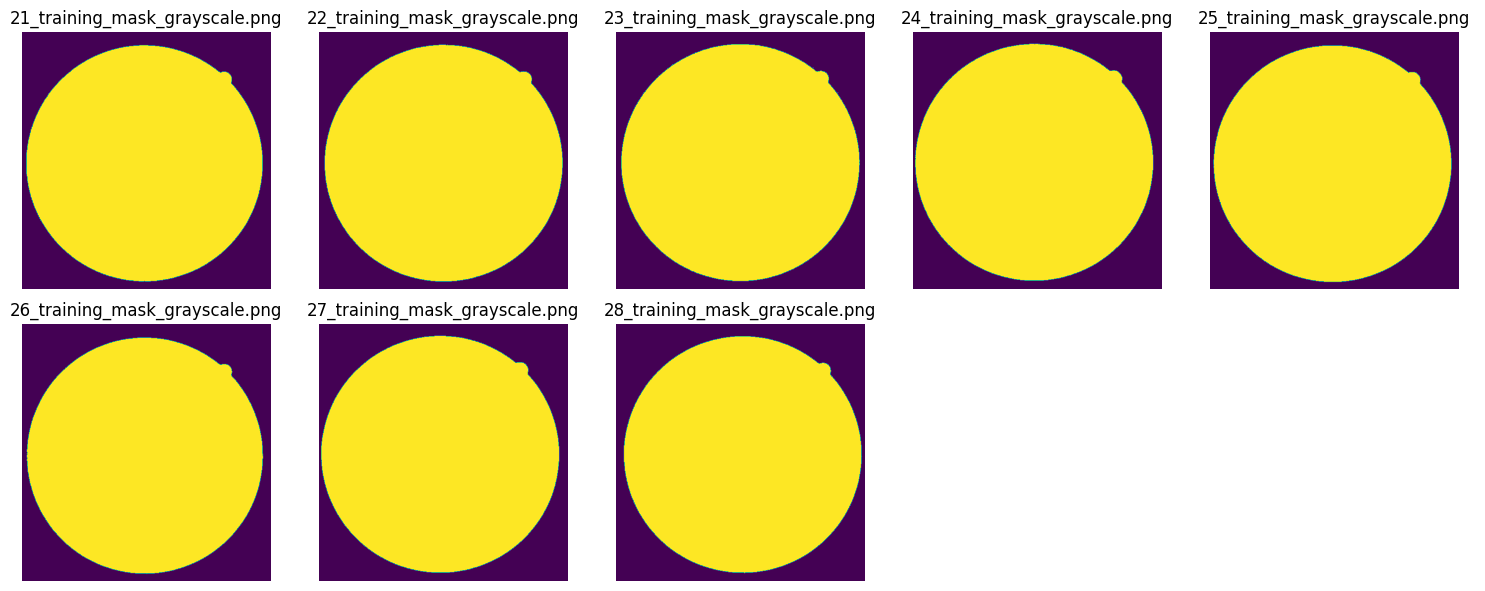

In [44]:
folder_path = './dataset/dataset_eye/train/train_y'
display_images_in_folder(folder_path)

In [23]:
import cv2
import numpy as np
import pandas as pd
from kartezio.dataset import read_dataset
from kartezio.easy import print_stats
from kartezio.fitness import FitnessAP
from kartezio.inference import ModelPool
from kartezio.preprocessing import TransformToHED, TransformToHSV
from numena.image.basics import image_normalize
from numena.image.contour import contours_draw, contours_find
from train_model import COLORS_SCALES

MODES = ["MCW", "LMW", "ELLIPSE", "HCT", "LABELS"]
dataset = read_dataset(f"./dataset/dataset_eye", counting=True, preview=True)

mode = "MCW"
scores_all = {}

preprocessing = None

color_scale = "RGB"
pool = ModelPool(
    './results/eye/MCW/RGB', FitnessAP(), regex="*/elite.json"
)
annotations_test = 0
annotations_training = 0
roi_pixel_areas = []
for y_true in dataset.train_y:
    n_annotations = y_true[1]
    annotations_training += n_annotations
for y_true in dataset.test_y:
    annotations = y_true[0]
    n_annotations = y_true[1]
    annotations_test += n_annotations
    for i in range(1, n_annotations + 1):
        roi_pixel_areas.append(np.count_nonzero(annotations[annotations == i]))
print(f"Total annotations for training set: {annotations_training}")
print(f"Total annotations for test set: {annotations_test}")
print(f"Mean pixel area for test set: {np.mean(roi_pixel_areas)}")

scores_test = []
scores_training = []
for i, model in enumerate(pool.models):
    # Test set

    p_test, fitness, t = model.eval(
        dataset, subset="test", preprocessing=preprocessing
    )

    scores_test.append(1.0 - fitness)
    for j, p_test_i in enumerate(p_test):
        visual = dataset.test_v[j]
        labels = p_test_i["labels"]
        n_labels = labels.max()
        for k in range(n_labels):
            labels_unique = labels.copy()
            labels_unique[labels_unique != k + 1] = 0
            visual = contours_draw(
                visual,
                contours_find(labels_unique.astype(np.uint8)),
                color=[72, 137, 62],
                thickness=2,
            )
        if "mask_raw" in p_test_i:
            cm_mask = cv2.applyColorMap(
                (image_normalize(p_test_i["mask_raw"]) * 255).astype(np.uint8),
                cv2.COLORMAP_VIRIDIS,
            )
        else:
            cm_mask = cv2.applyColorMap(
                (image_normalize(p_test_i["mask"]) * 255).astype(np.uint8),
                cv2.COLORMAP_VIRIDIS,
            )

    # Training set
    p_train, fitness, _ = model.eval(
        dataset, subset="train", preprocessing=preprocessing
    )
    scores_training.append(1.0 - fitness)

scores_all[f"training_{color_scale}"] = scores_training
scores_all[f"test_{color_scale}"] = scores_test
print_stats(scores_training, "AP50", f"{mode} {color_scale} training set")
print_stats(scores_test, "AP50", f"{mode} {color_scale} test set")

pd.DataFrame(scores_all).to_csv(f"./results/{mode}_results.csv", index=False)

Total annotations for training set: 10
Total annotations for test set: 4
Mean pixel area for test set: 226803.25
-- Statistics for MCW RGB training set, using AP50 fitness:
Min 	 Mean +/- SD 	 Max
0.917 	 0.917+/-0.000 	 0.917
-- Statistics for MCW RGB test set, using AP50 fitness:
Min 	 Mean +/- SD 	 Max
1.000 	 1.000+/-0.000 	 1.000


However, for gray image and cancer, its performance is not good enough.

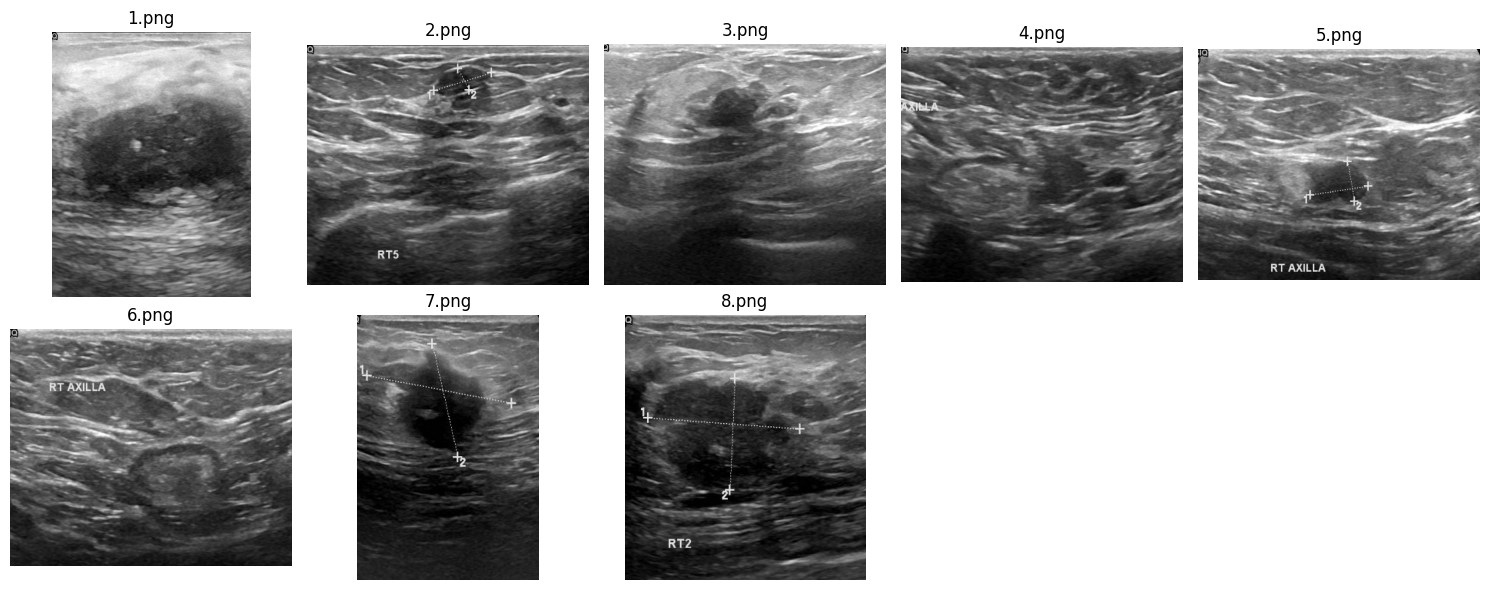

In [46]:
folder_path = './dataset/breast/train/train_x'
display_images_in_folder(folder_path)

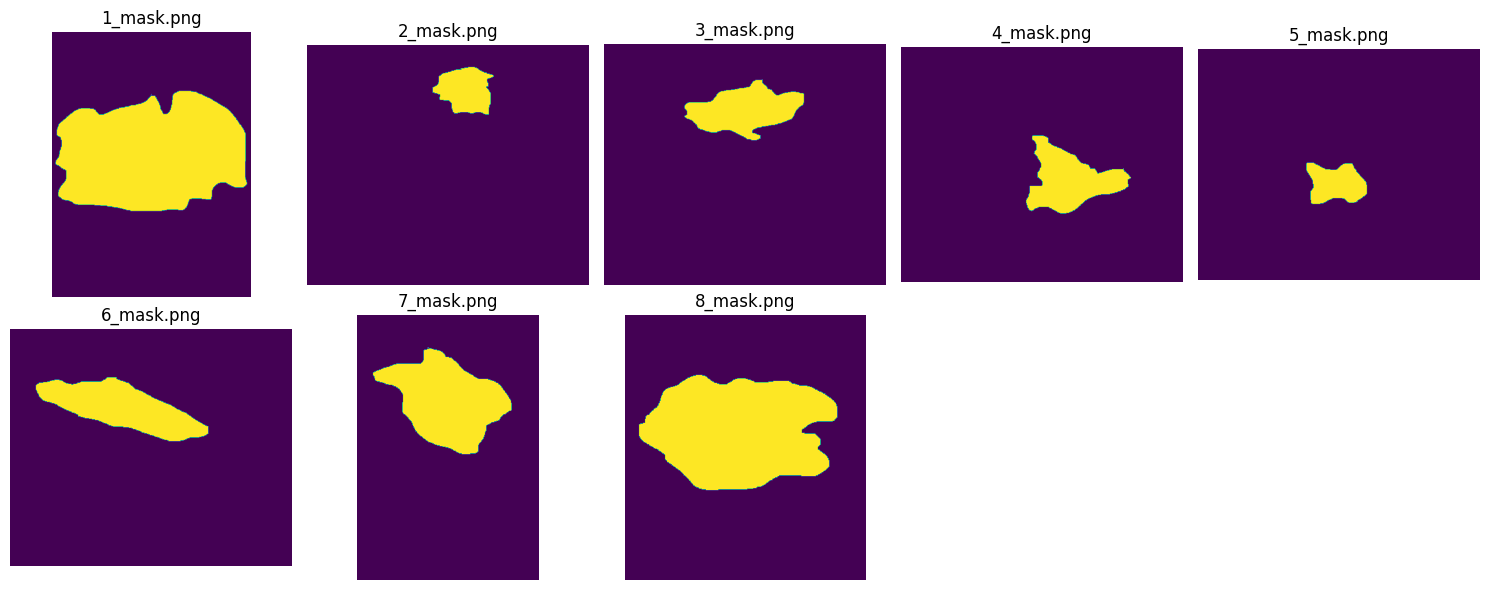

In [48]:
folder_path = './dataset/breast/train/train_y'
display_images_in_folder(folder_path)

In [24]:
import cv2
import numpy as np
import pandas as pd
from kartezio.dataset import read_dataset
from kartezio.easy import print_stats
from kartezio.fitness import FitnessAP
from kartezio.inference import ModelPool
from kartezio.preprocessing import TransformToHED, TransformToHSV
from numena.image.basics import image_normalize
from numena.image.contour import contours_draw, contours_find
from train_model import COLORS_SCALES

MODES = ["MCW", "LMW", "ELLIPSE", "HCT", "LABELS"]
dataset = read_dataset(f"./dataset/breast", counting=True, preview=True)

mode = "MCW"
scores_all = {}

preprocessing = None

color_scale = "RGB"
pool = ModelPool(
    './results/breast/MCW/RGB', FitnessAP(), regex="*/elite.json"
)
annotations_test = 0
annotations_training = 0
roi_pixel_areas = []
for y_true in dataset.train_y:
    n_annotations = y_true[1]
    annotations_training += n_annotations
for y_true in dataset.test_y:
    annotations = y_true[0]
    n_annotations = y_true[1]
    annotations_test += n_annotations
    for i in range(1, n_annotations + 1):
        roi_pixel_areas.append(np.count_nonzero(annotations[annotations == i]))
print(f"Total annotations for training set: {annotations_training}")
print(f"Total annotations for test set: {annotations_test}")
print(f"Mean pixel area for test set: {np.mean(roi_pixel_areas)}")

scores_test = []
scores_training = []
for i, model in enumerate(pool.models):
    # Test set

    p_test, fitness, t = model.eval(
        dataset, subset="test", preprocessing=preprocessing
    )

    scores_test.append(1.0 - fitness)
    for j, p_test_i in enumerate(p_test):
        visual = dataset.test_v[j]
        labels = p_test_i["labels"]
        n_labels = labels.max()
        for k in range(n_labels):
            labels_unique = labels.copy()
            labels_unique[labels_unique != k + 1] = 0
            visual = contours_draw(
                visual,
                contours_find(labels_unique.astype(np.uint8)),
                color=[72, 137, 62],
                thickness=2,
            )
        if "mask_raw" in p_test_i:
            cm_mask = cv2.applyColorMap(
                (image_normalize(p_test_i["mask_raw"]) * 255).astype(np.uint8),
                cv2.COLORMAP_VIRIDIS,
            )
        else:
            cm_mask = cv2.applyColorMap(
                (image_normalize(p_test_i["mask"]) * 255).astype(np.uint8),
                cv2.COLORMAP_VIRIDIS,
            )

    # Training set
    p_train, fitness, _ = model.eval(
        dataset, subset="train", preprocessing=preprocessing
    )
    scores_training.append(1.0 - fitness)

scores_all[f"training_{color_scale}"] = scores_training
scores_all[f"test_{color_scale}"] = scores_test
print_stats(scores_training, "AP50", f"{mode} {color_scale} training set")
print_stats(scores_test, "AP50", f"{mode} {color_scale} test set")

pd.DataFrame(scores_all).to_csv(f"./results/{mode}_results.csv", index=False)

Total annotations for training set: 10
Total annotations for test set: 21
Mean pixel area for test set: 29854.14285714286
-- Statistics for MCW RGB training set, using AP50 fitness:
Min 	 Mean +/- SD 	 Max
0.208 	 0.208+/-0.000 	 0.208
-- Statistics for MCW RGB test set, using AP50 fitness:
Min 	 Mean +/- SD 	 Max
0.019 	 0.019+/-0.000 	 0.019
